# Dueling Networks from Scratch

The dueling architecture explicitly separates the representation of state values from (state-dependent) action advantage values.

# Imports & Constants

In [1]:
import sys
import os

# Assuming the notebook is located inside `subfolder` and
# we want to import a module in `parent_folder`

# Get the absolute path to the 'subfolder'.
notebook_dir = os.path.dirname(os.path.abspath("__file__"))

# Calculate the path to the 'parent_folder' by going one level up.
parent_dir = os.path.dirname(notebook_dir)

# Add the 'parent_folder' to sys.path if it is not already there.
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [2]:
import os
from typing import Dict, List, Tuple

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd

from IPython.display import clear_output
from torch.nn.utils import clip_grad_norm_

from buffers import ReplayBuffer
import time
from agents import MlpDQNAgent

# Dueling Network

In [3]:
class DuelingNetwork(nn.Module):

    def __init__(self, in_dim: int, out_dim: int):
        """
        Instantiates a Duelling Neural Network.
        """
        super().__init__()

        # Common feature layer.
        self.feature_layer = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
        )

        # Advantage layer
        self.advantage_layer = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, out_dim),
        )

        # Value layer
        self.value_layer = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Performs a forward pass of the neural network.
        """
        feature = self.feature_layer(x)

        s_value = self.value_layer(feature)
        advantage = self.advantage_layer(feature)

        q_value = s_value + advantage - advantage.mean(dim=-1, keepdim=True)

        return q_value

# Dueling DQN Agent

In [4]:
class DuelingDQNAgent(MlpDQNAgent):
    """
    Class representing a DQN agent with Dueling Networks.
    """

    def __init__(
        self,
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        target_update: int,
        epsilon_decay: float,
        seed: int,
        max_epsilon: float = 1.0,
        min_epsilon: float = 0.1,
        gamma: float = 0.99,
    ):
        super().__init__(
            env, 
            memory_size, 
            batch_size, 
            target_update, 
            epsilon_decay, 
            seed, 
            max_epsilon, 
            min_epsilon, 
            gamma
        )

        # Networks: DQN behaviour network, DQN target network
        self.dqn = DuelingNetwork(self.obs_dim, self.action_dim).to(self.device)
        self.dqn_target = DuelingNetwork(self.obs_dim, self.action_dim).to(self.device)
        self.dqn_target.load_state_dict(self.dqn.state_dict())
        self.dqn_target.eval()

        # Optimiser
        self.optimiser = optim.Adam(self.dqn.parameters())
    
    def update_model(self) -> torch.Tensor:
        """
        Updates the model by gradient descent.
        """
        samples = self.memory.sample_batch()

        loss = self._compute_dqn_loss(samples)
        
        self.optimiser.zero_grad()
        loss.backward()

        # Dueling DQN: We clip the gradients to have their norm less than or equal to 10.
        clip_grad_norm_(self.dqn.parameters(), 10.0)

        self.optimiser.step()

        return loss.item()

# Train an agent

In [16]:
config = {
    'duration': 50,
    'lanes_count': 4,
}

In [17]:
env = gym.make("highway-fast-v0", render_mode="rgb_array")
env.unwrapped.configure(config)
obs, info = env.reset()

In [7]:
seed = 777
num_frames = 200_000
memory_size = 10_000
gamma = 0.85
batch_size = 64
target_update = 50
epsilon_decay = 1 / (num_frames // 10)

agent = DuelingDQNAgent(
    env,
    memory_size,
    batch_size,
    target_update,
    epsilon_decay,
    seed,
    gamma = gamma
)

cuda


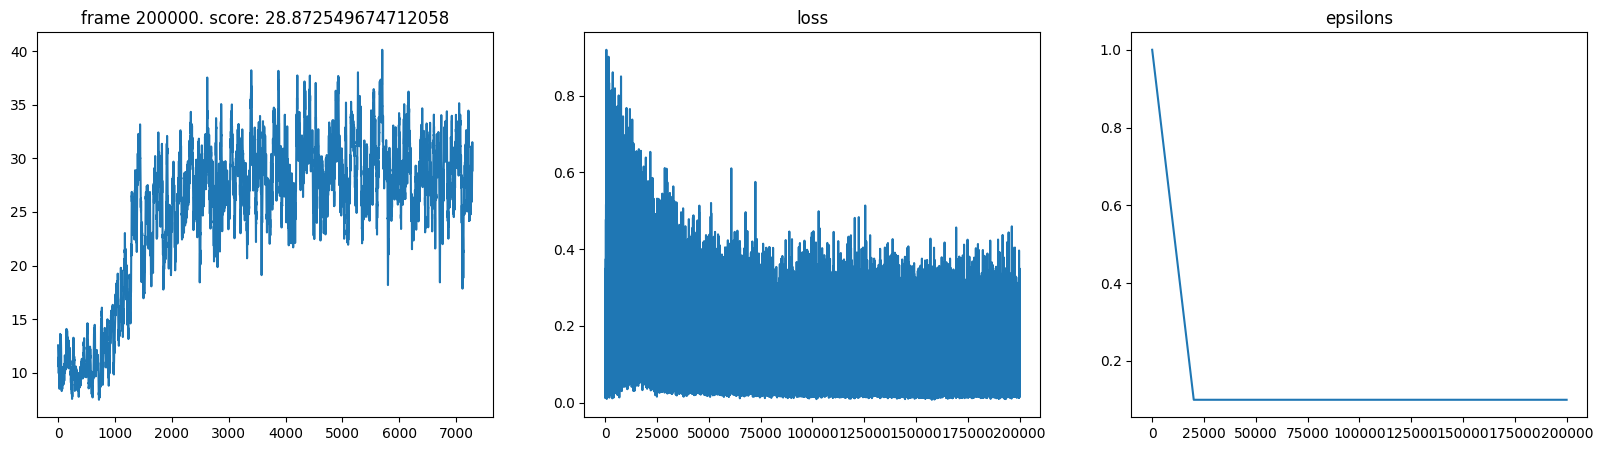

In [8]:
scores, losses, epsilons = agent.train(num_frames)

In [9]:
# pd.DataFrame({"Dueling DQN": scores}).to_csv("../results/dueling_dqn.csv")

# Test the agent

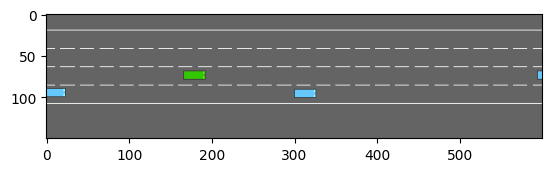

In [10]:
ep_lens, ep_rews = agent.test(1, time_interval=0.01)

In [11]:
print("Mean Episode Length:", np.mean(ep_lens))
print("Mean Score Per Episode:", np.mean(ep_rews))

Mean Episode Length: 50.0
Mean Score Per Episode: 46.746812789701664


# Film the agent

In [22]:
from gymnasium.wrappers import RecordVideo
from agents import BaseDQNAgent

In [23]:
env = gym.make("highway-v0", render_mode="rgb_array")

In [24]:
def film(env: gym.Env, test_agent: BaseDQNAgent, film_length: int, video_folder: str):
    vid_env = RecordVideo(env, video_folder=video_folder,
              episode_trigger=lambda e: True)  # record all episodes

    # Provide the video recorder to the wrapped environment
    # so it can send it intermediate simulation frames.
    vid_env.unwrapped.set_record_video_wrapper(vid_env)

    test_agent.set_mode(is_test=True)

    for i in range(film_length):
        obs, info = vid_env.reset()
        done = truncated = False

        while not (done or truncated):
            action = test_agent.predict(obs, determinstic=True)
            obs, reward, done, truncated, info = vid_env.step(action)
            vid_env.render()
        vid_env.close()

## Before Training

In [25]:
untrained_agent = DuelingDQNAgent(
    env,
    memory_size,
    batch_size,
    target_update,
    epsilon_decay,
    seed,
    gamma = gamma
)

film(env, untrained_agent, 10, "../videos/dueling_dqn/untrained/")

cuda


/home/sowell/projects/rl_group_assignment/venv/lib/python3.11/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /home/sowell/projects/rl_group_assignment/videos/dueling_dqn/untrained folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/dueling_dqn/untrained/rl-video-episode-0.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/dueling_dqn/untrained/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/dueling_dqn/untrained/rl-video-episode-0.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/dueling_dqn/untrained/rl-video-episode-1.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/dueling_dqn/untrained/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/dueling_dqn/untrained/rl-video-episode-1.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/dueling_dqn/untrained/rl-video-episode-2.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/dueling_dqn/untrained/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/dueling_dqn/untrained/rl-video-episode-2.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/dueling_dqn/untrained/rl-video-episode-3.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/dueling_dqn/untrained/rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/dueling_dqn/untrained/rl-video-episode-3.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/dueling_dqn/untrained/rl-video-episode-4.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/dueling_dqn/untrained/rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/dueling_dqn/untrained/rl-video-episode-4.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/dueling_dqn/untrained/rl-video-episode-5.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/dueling_dqn/untrained/rl-video-episode-5.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/dueling_dqn/untrained/rl-video-episode-5.mp4


Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/dueling_dqn/untrained/rl-video-episode-6.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/dueling_dqn/untrained/rl-video-episode-6.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/dueling_dqn/untrained/rl-video-episode-6.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/dueling_dqn/untrained/rl-video-episode-7.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/dueling_dqn/untrained/rl-video-episode-7.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/dueling_dqn/untrained/rl-video-episode-7.mp4


Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/dueling_dqn/untrained/rl-video-episode-8.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/dueling_dqn/untrained/rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/dueling_dqn/untrained/rl-video-episode-8.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/dueling_dqn/untrained/rl-video-episode-9.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/dueling_dqn/untrained/rl-video-episode-9.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/dueling_dqn/untrained/rl-video-episode-9.mp4


## After training

In [26]:
film(env, agent, 10, "../videos/dueling_dqn/trained/")

/home/sowell/projects/rl_group_assignment/venv/lib/python3.11/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /home/sowell/projects/rl_group_assignment/videos/dueling_dqn/trained folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/dueling_dqn/trained/rl-video-episode-0.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/dueling_dqn/trained/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/dueling_dqn/trained/rl-video-episode-0.mp4


Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/dueling_dqn/trained/rl-video-episode-1.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/dueling_dqn/trained/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/dueling_dqn/trained/rl-video-episode-1.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/dueling_dqn/trained/rl-video-episode-2.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/dueling_dqn/trained/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/dueling_dqn/trained/rl-video-episode-2.mp4


Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/dueling_dqn/trained/rl-video-episode-3.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/dueling_dqn/trained/rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/dueling_dqn/trained/rl-video-episode-3.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/dueling_dqn/trained/rl-video-episode-4.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/dueling_dqn/trained/rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/dueling_dqn/trained/rl-video-episode-4.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/dueling_dqn/trained/rl-video-episode-5.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/dueling_dqn/trained/rl-video-episode-5.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/dueling_dqn/trained/rl-video-episode-5.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/dueling_dqn/trained/rl-video-episode-6.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/dueling_dqn/trained/rl-video-episode-6.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/dueling_dqn/trained/rl-video-episode-6.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/dueling_dqn/trained/rl-video-episode-7.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/dueling_dqn/trained/rl-video-episode-7.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/dueling_dqn/trained/rl-video-episode-7.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/dueling_dqn/trained/rl-video-episode-8.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/dueling_dqn/trained/rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/dueling_dqn/trained/rl-video-episode-8.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/dueling_dqn/trained/rl-video-episode-9.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/dueling_dqn/trained/rl-video-episode-9.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/dueling_dqn/trained/rl-video-episode-9.mp4
